In [3]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [4]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [5]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   SAIA    1259 non-null   float64
 3   AXP     1259 non-null   float64
 4   TROW    1259 non-null   float64
 5   CG      1259 non-null   float64
 6   CSWC    1259 non-null   float64
 7   CBRE    1259 non-null   float64
 8   SBAC    1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  QCOM    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  DSGX    1259 non-null   float64
 13  MGIC    1259 non-null   float64
 14  RDWR    1259 non-null   float64
 15  CTLT    1259 non-null   float64
 16  BRKR    1259 non-null   float64
 17  ICLR    1259 non-null   float64
 18  MODV    1259 non-null   float64
 19  ^FVX    1259 non-null   float64
dtypes: float64(20)
memory usage: 206.6 KB


## Function that saves dataframe to CSV

In [6]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [7]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [8]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [9]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [10]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [11]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [12]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [13]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [14]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [15]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

#add in the weightage of stocks
port_shares = [0.0096774,0.045642,0.0046806,0.0007318,0.0054878,0.0079948,0.0057856,0.028368,0.061632,
               0.0030595,8.10E-06,0.0034595,0.0020299,0.0009189,0.0005241,0.0058504,0.004437,0.0067168,
               0.0029958,0.8]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.907389,2.587344,0.210159,0.051066,0.355386,0.097762,0.073813,0.895578,6.380812,0.194768,...,0.043135,0.005395,0.007694,0.157961,0.093785,0.501812,0.114949,1.5552,14.598426,NaN
2017-01-04,0.912336,2.598078,0.210861,0.051903,0.360681,0.100582,0.075620,0.910045,6.389882,0.196909,...,0.043541,0.005434,0.007736,0.159774,0.094741,0.515985,0.117975,1.5576,14.672356,0.005064
2017-01-05,0.913484,2.567368,0.205712,0.051263,0.357869,0.102149,0.075529,0.902386,6.305233,0.198103,...,0.042932,0.005473,0.007699,0.157376,0.094958,0.511887,0.117435,1.4904,14.474282,-0.013500
2017-01-06,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,1.5376,14.494217,0.001377
2017-01-09,0.902266,2.553057,0.206414,0.051631,0.341281,0.104656,0.075529,0.883096,6.227232,0.204497,...,0.043034,0.005434,0.007599,0.157434,0.096827,0.539829,0.117316,1.5048,14.393076,-0.006978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,1.750367,9.013694,0.868111,0.084675,0.776573,0.244024,0.091072,1.785198,16.783237,1.090222,...,0.121185,0.013546,0.014235,0.616106,0.240375,1.293051,0.411833,0.2912,37.151988,0.006010
2020-12-28,1.770786,8.861838,0.855754,0.085403,0.775421,0.244646,0.093765,1.786333,16.858299,1.081931,...,0.118790,0.013440,0.014491,0.601889,0.238118,1.285461,0.418154,0.2912,37.049191,-0.002767
2020-12-29,1.761049,8.826373,0.853414,0.085245,0.777097,0.243246,0.094534,1.761936,16.843045,1.076179,...,0.120556,0.013812,0.014476,0.600895,0.236437,1.299701,0.402845,0.3024,36.979688,-0.001876


## Get old data for portfolio

In [16]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.907389,2.587344,0.210159,0.051066,0.355386,0.097762,0.073813,0.895578,6.380812,0.194768,...,0.043135,0.005395,0.007694,0.157961,0.093785,0.501812,0.114949,1.5552,14.598426,NaN
2017-01-04,0.912336,2.598078,0.210861,0.051903,0.360681,0.100582,0.075620,0.910045,6.389882,0.196909,...,0.043541,0.005434,0.007736,0.159774,0.094741,0.515985,0.117975,1.5576,14.672356,0.005064
2017-01-05,0.913484,2.567368,0.205712,0.051263,0.357869,0.102149,0.075529,0.902386,6.305233,0.198103,...,0.042932,0.005473,0.007699,0.157376,0.094958,0.511887,0.117435,1.4904,14.474282,-0.013500
2017-01-06,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,1.5376,14.494217,0.001377
2017-01-09,0.902266,2.553057,0.206414,0.051631,0.341281,0.104656,0.075529,0.883096,6.227232,0.204497,...,0.043034,0.005434,0.007599,0.157434,0.096827,0.539829,0.117316,1.5048,14.393076,-0.006978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,1.750367,9.013694,0.868111,0.084675,0.776573,0.244024,0.091072,1.785198,16.783237,1.090222,...,0.121185,0.013546,0.014235,0.616106,0.240375,1.293051,0.411833,0.2912,37.151988,0.006010
2020-12-28,1.770786,8.861838,0.855754,0.085403,0.775421,0.244646,0.093765,1.786333,16.858299,1.081931,...,0.118790,0.013440,0.014491,0.601889,0.238118,1.285461,0.418154,0.2912,37.049191,-0.002767
2020-12-29,1.761049,8.826373,0.853414,0.085245,0.777097,0.243246,0.094534,1.761936,16.843045,1.076179,...,0.120556,0.013812,0.014476,0.600895,0.236437,1.299701,0.402845,0.3024,36.979688,-0.001876


## Forecasting

In [17]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [18]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [19]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.907389,2.587344,0.210159,0.051066,0.355386,0.097762,0.073813,0.895578,6.380812,0.194768,...,0.043135,0.005395,0.007694,0.157961,0.093785,0.501812,0.114949,1.5552,14.598426,NaN
2017-01-04,0.912336,2.598078,0.210861,0.051903,0.360681,0.100582,0.075620,0.910045,6.389882,0.196909,...,0.043541,0.005434,0.007736,0.159774,0.094741,0.515985,0.117975,1.5576,14.672356,0.005064
2017-01-05,0.913484,2.567368,0.205712,0.051263,0.357869,0.102149,0.075529,0.902386,6.305233,0.198103,...,0.042932,0.005473,0.007699,0.157376,0.094958,0.511887,0.117435,1.4904,14.474282,-0.013500
2017-01-06,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,1.5376,14.494217,0.001377
2017-01-07,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,1.5376,14.494217,0.001377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.750367,9.013694,0.868111,0.084675,0.776573,0.244024,0.091072,1.785198,16.783237,1.090222,...,0.121185,0.013546,0.014235,0.616106,0.240375,1.293051,0.411833,0.2912,37.151988,0.006010
2020-12-28,1.770786,8.861838,0.855754,0.085403,0.775421,0.244646,0.093765,1.786333,16.858299,1.081931,...,0.118790,0.013440,0.014491,0.601889,0.238118,1.285461,0.418154,0.2912,37.049191,-0.002767
2020-12-29,1.761049,8.826373,0.853414,0.085245,0.777097,0.243246,0.094534,1.761936,16.843045,1.076179,...,0.120556,0.013812,0.014476,0.600895,0.236437,1.299701,0.402845,0.3024,36.979688,-0.001876


In [20]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [21]:
tot_port_df

,Total
Date,
2017-01-03,14.598426
2017-01-04,14.672356
2017-01-05,14.474282
2017-01-06,14.494217
2017-01-07,14.494217
...,...
2020-12-27,37.151988
2020-12-28,37.049191
2020-12-29,36.979688


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Observations : 1459


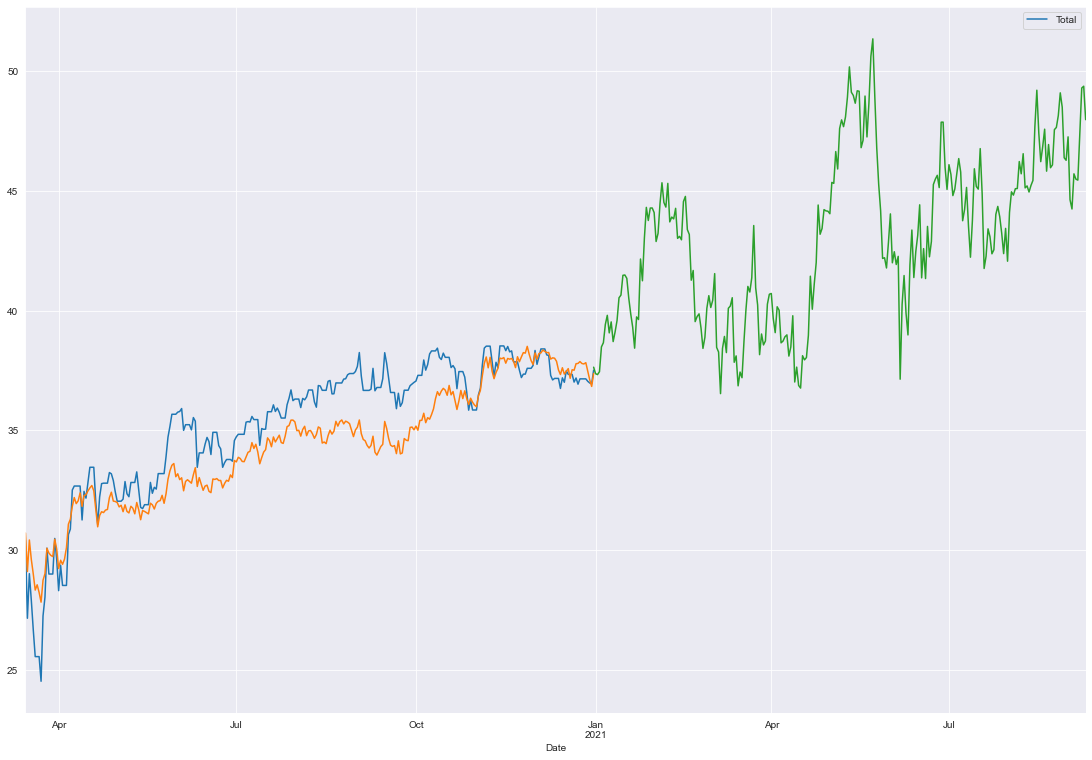

In [22]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [23]:
forecast

2020-12-31    37.638191
2021-01-01    37.366480
2021-01-02    37.329544
2021-01-03    37.452271
2021-01-04    38.484414
                ...    
2021-09-05    45.434408
2021-09-06    47.333878
2021-09-07    49.273946
2021-09-08    49.348006
2021-09-09    47.955110
Freq: D, Length: 253, dtype: float64

In [24]:
forecast_df = pd.DataFrame(forecast)

In [25]:
forecast_df

,0
2020-12-31,37.638191
2021-01-01,37.366480
2021-01-02,37.329544
2021-01-03,37.452271
2021-01-04,38.484414
...,...
2021-09-05,45.434408
2021-09-06,47.333878
2021-09-07,49.273946
2021-09-08,49.348006


In [26]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [27]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.007219
2021-01-02,-0.008200
2021-01-03,-0.004940
2021-01-04,0.022483
...,...
2021-09-05,0.207136
2021-09-06,0.257602
2021-09-07,0.309148
2021-09-08,0.311115


In [28]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2021-09-09  27.410773


## Backtesting

In [29]:
tickers2 = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [30]:
panel_data2 = panel_data2['Adj Close']

In [31]:
panel_data2

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,QCOM,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX
Date,,,,,,,,,,,,,,,,,,,,
2020-12-30,183.303925,192.874649,182.320007,117.758217,142.749680,30.581200,16.510559,62.400002,271.858215,358.480011,146.624542,487.229980,58.139999,15.175846,27.559999,103.190002,53.357384,193.660004,137.899994,0.370
2020-12-31,184.642197,194.428650,180.800003,119.217499,144.477051,30.600668,16.862049,62.720001,279.353729,358.350006,148.961548,485.051971,58.480000,15.098663,27.750000,104.070000,53.975616,194.979996,138.630005,0.361
2021-01-04,176.260910,189.955933,179.929993,116.387672,140.945999,30.279476,16.938046,59.500000,272.917694,348.059998,145.206696,497.264771,57.730000,14.432972,27.280001,103.730003,53.157955,192.020004,141.360001,0.354
2021-01-05,178.126678,191.011871,180.860001,117.008850,142.282059,30.600668,16.890549,59.419998,269.897705,345.700012,149.049545,502.595459,58.820000,14.375085,27.350000,104.830002,54.165077,195.690002,145.679993,0.377
2021-01-06,178.536972,192.555908,187.009995,121.337395,144.610641,30.201616,16.748049,60.610001,262.035889,329.660004,147.837051,487.538300,57.200001,14.124246,27.400000,106.239998,56.109516,205.479996,155.580002,0.432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,207.347183,347.977234,323.529999,163.778946,193.571014,55.196152,24.795002,105.820000,373.462097,663.080017,181.980865,801.409973,80.900002,20.666519,38.340000,124.959999,80.223610,307.929993,152.139999,1.243
2021-12-27,209.408127,355.260284,333.049988,163.978439,197.565552,55.852657,24.579479,107.790001,382.522247,697.000000,185.555954,811.429993,81.820000,21.160698,40.820000,126.360001,82.701866,307.619995,151.100006,1.252
2021-12-28,211.230103,356.299286,330.190002,163.998398,197.654755,55.176258,24.520700,107.720001,383.889252,682.200012,184.052231,804.770020,82.000000,20.824657,40.430000,125.360001,82.022346,306.049988,149.979996,1.245


## Portfolio Analysis

In [32]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,QCOM,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX
Date,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.007301,0.008057,-0.008337,0.012392,0.012101,0.000637,0.021289,0.005128,0.027571,-0.000363,0.015939,-0.004470,0.005848,-0.005086,0.006894,0.008528,0.011587,0.006816,0.005294,-0.024324
2021-01-04,-0.045392,-0.023004,-0.004812,-0.023737,-0.024440,-0.010496,0.004507,-0.051339,-0.023039,-0.028715,-0.025207,0.025178,-0.012825,-0.044089,-0.016937,-0.003267,-0.015149,-0.015181,0.019693,-0.019391
2021-01-05,0.010585,0.005559,0.005169,0.005337,0.009479,0.010608,-0.002804,-0.001345,-0.011066,-0.006780,0.026465,0.010720,0.018881,-0.004011,0.002566,0.010604,0.018946,0.019113,0.030560,0.064972
2021-01-06,0.002303,0.008083,0.034004,0.036993,0.016366,-0.013041,-0.008437,0.020027,-0.029129,-0.046399,-0.008135,-0.029959,-0.027542,-0.017450,0.001828,0.013450,0.035898,0.050028,0.067957,0.145889
2021-01-07,-0.008317,0.044801,0.036790,-0.007910,0.019930,0.014180,0.044243,0.014684,0.002305,0.026755,0.029830,0.022867,0.024475,0.019126,0.015328,0.021931,0.031100,0.019321,0.046150,0.050926


In [33]:
portfolio_weights = [0.0096774,0.045642,0.0046806,0.0007318,0.0054878,0.0079948,0.0057856,0.028368,0.061632,
               0.0030595,8.10E-06,0.0034595,0.0020299,0.0009189,0.0005241,0.0058504,0.004437,0.0067168,
               0.0029958,0.8]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,QCOM,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX
Date,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.000071,0.000368,-0.000039,0.000009,0.000066,0.000005,0.000123,0.000145,0.001699,-0.000001,1.291035e-07,-0.000015,0.000012,-0.000005,3.613181e-06,0.000050,0.000051,0.000046,0.000016,-0.019459
2021-01-04,-0.000439,-0.001050,-0.000023,-0.000017,-0.000134,-0.000084,0.000026,-0.001456,-0.001420,-0.000088,-2.041755e-07,0.000087,-0.000026,-0.000041,-8.876636e-06,-0.000019,-0.000067,-0.000102,0.000059,-0.015512
2021-01-05,0.000102,0.000254,0.000024,0.000004,0.000052,0.000085,-0.000016,-0.000038,-0.000682,-0.000021,2.143640e-07,0.000037,0.000038,-0.000004,1.344825e-06,0.000062,0.000084,0.000128,0.000092,0.051977
2021-01-06,0.000022,0.000369,0.000159,0.000027,0.000090,-0.000104,-0.000049,0.000568,-0.001795,-0.000142,-6.589219e-08,-0.000104,-0.000056,-0.000016,9.581207e-07,0.000079,0.000159,0.000336,0.000204,0.116711
2021-01-07,-0.000080,0.002045,0.000172,-0.000006,0.000109,0.000113,0.000256,0.000417,0.000142,0.000082,2.416227e-07,0.000079,0.000050,0.000018,8.033651e-06,0.000128,0.000138,0.000130,0.000138,0.040741


In [34]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31   -0.016854
2021-01-04   -0.020316
2021-01-05    0.052181
2021-01-06    0.116459
2021-01-07    0.044680
dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,208.8%
Cumulative returns,208.8%
Annual volatility,59.4%
Sharpe ratio,2.19
Calmar ratio,8.92
Stability,0.75
Max drawdown,-23.4%


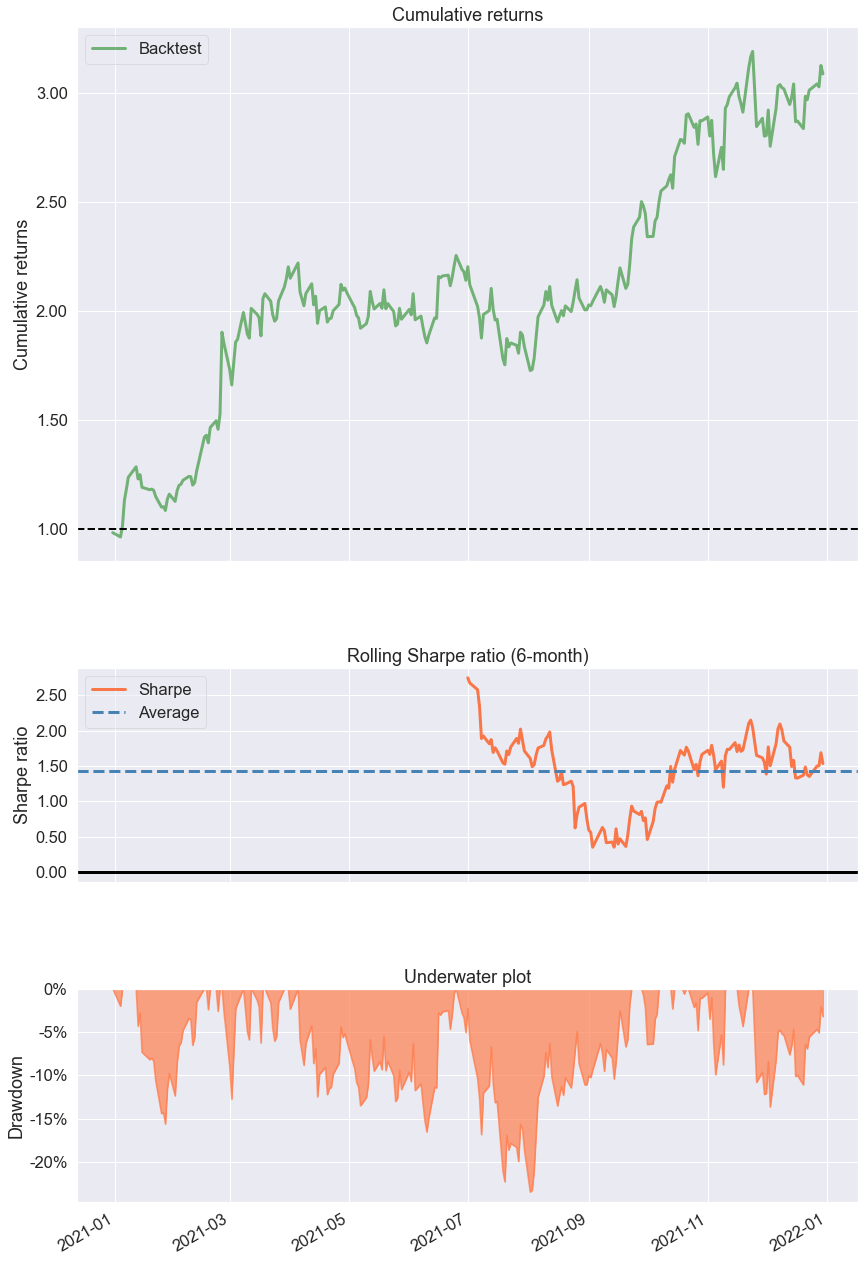

In [35]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [36]:
import itertools

In [37]:
weights = [0.0096774,0.045642,0.0046806,0.0007318,0.0054878,0.0079948,0.0057856,0.028368,0.061632,
               0.0030595,8.10E-06,0.0034595,0.0020299,0.0009189,0.0005241,0.0058504,0.004437,0.0067168,
               0.0029958,0.8]

In [38]:
panel_data2 = panel_data2 * weights

In [39]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [40]:
#forecasted portfolio value
panel_data2

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,1.773905,8.803185,0.853367,0.086175,0.783382,0.244491,0.095523,1.770163,16.755166,1.096770,...,1.685572,0.118018,0.013945,0.014444,0.603703,0.236747,1.300776,0.413121,0.2960,36.945640
2020-12-31,1.786856,8.874112,0.846252,0.087243,0.792861,0.244646,0.097557,1.779241,17.217129,1.096372,...,1.678037,0.118709,0.013874,0.014544,0.608851,0.239490,1.309642,0.415308,0.2888,37.510732
2021-01-04,1.705747,8.669969,0.842180,0.085172,0.773483,0.242078,0.097997,1.687896,16.820463,1.064890,...,1.720287,0.117186,0.013262,0.014297,0.606862,0.235862,1.289760,0.423486,0.2832,36.695256
2021-01-05,1.723803,8.718164,0.846533,0.085627,0.780815,0.244646,0.097722,1.685627,16.634335,1.057669,...,1.738729,0.119399,0.013209,0.014334,0.613297,0.240330,1.314411,0.436428,0.3016,36.667887
2021-01-06,1.727774,8.788637,0.875319,0.088795,0.793594,0.241456,0.096898,1.719384,16.149796,1.008595,...,1.686639,0.116110,0.012979,0.014360,0.621546,0.248958,1.380168,0.466087,0.3456,36.383892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,2.006582,15.882377,1.514315,0.119853,1.062279,0.441282,0.143454,3.001902,23.017216,2.028693,...,2.772478,0.164219,0.018990,0.020094,0.731066,0.355952,2.068304,0.455781,0.9944,56.800711
2021-12-27,2.026526,16.214790,1.558874,0.119999,1.084200,0.446531,0.142207,3.057787,23.575611,2.132472,...,2.807142,0.166086,0.019445,0.021394,0.739257,0.366948,2.066222,0.452665,1.0016,58.001259
2021-12-28,2.044158,16.262212,1.545487,0.120014,1.084690,0.441123,0.141867,3.055801,23.659862,2.087191,...,2.784102,0.166452,0.019136,0.021189,0.733406,0.363933,2.055677,0.449310,0.9960,58.033101


In [41]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [42]:
actual_portfolio_value

[36.945640003777115,
 37.51073173570901,
 36.6952560758234,
 36.667887094242,
 36.38389162010947,
 37.03680777226705,
 37.49534432134295,
 36.929418835319694,
 37.07922599294089,
 37.13883064590053,
 37.60044282471008,
 37.84500399259776,
 38.05551378543605,
 38.474787345215226,
 38.383592078771784,
 38.215166954483216,
 38.65484034441298,
 38.29472051326351,
 37.04454874544563,
 37.3899175309721,
 36.82311700901995,
 37.907115207233225,
 38.58743134061137,
 37.58763280596561,
 38.23126237751123,
 38.4369173958003,
 38.399354095792965,
 38.55251820769692,
 38.29556366585217,
 38.40618271888333,
 38.633582596165084,
 38.295340383536534,
 38.09298142568074,
 38.332455498393074,
 38.65796964964753,
 38.271489319146916,
 37.60655408103885,
 38.02857937303151,
 38.06730033259325,
 37.8730095392167,
 37.877553579457675,
 37.82520695427696,
 37.35501162165527,
 36.453730627367214,
 37.24954276344681,
 37.17563437964773,
 37.95244321045647,
 38.169029130362794,
 39.0668861492674,
 39.488895366

In [43]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [44]:
forecasted_portfolio_value

[37.638191014279265,
 37.36648031248055,
 37.32954449613487,
 37.452271080592574,
 38.484414072307544,
 38.65872083844414,
 39.41967998026639,
 39.80005446339613,
 39.0679671141987,
 39.52625172640103,
 38.705951951110485,
 39.11067465077193,
 39.58596989567552,
 40.531182773943044,
 40.64357633502127,
 41.46812569095792,
 41.48078256887967,
 41.340538291815946,
 40.51427234350126,
 39.86264480573163,
 39.31195207341159,
 38.43091227378761,
 39.7337982749679,
 39.62492493501265,
 42.146979928465356,
 41.23974883911051,
 43.019116816661544,
 44.29938891490906,
 43.753079409683735,
 44.27154983063053,
 44.27404363509472,
 44.08170617294836,
 42.876770801321186,
 43.21599329090317,
 44.459080022622665,
 45.3249809455962,
 44.50251097979173,
 44.310746148392994,
 45.29918556445761,
 43.69412848754854,
 43.8952406972297,
 43.81936249085251,
 44.259574587221906,
 43.007637934521114,
 43.090498442172674,
 42.94797081732884,
 44.5387112153252,
 44.755910409628456,
 43.37369072329997,
 43.17016

## Calculate MAPE of forecasted period

In [45]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.12
MAPE % : 11.64 %



## Mean Squared Error

In [46]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value))

43.755689805780165


## Forecast for future

In [47]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

#add in the weightage of stocks
port_shares = [0.0096774,0.045642,0.0046806,0.0007318,0.0054878,0.0079948,0.0057856,0.028368,0.061632,
               0.0030595,8.10E-06,0.0034595,0.0020299,0.0009189,0.0005241,0.0058504,0.004437,0.0067168,
               0.0029958,0.8]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.907389,2.587344,0.210159,0.051066,0.355386,0.097762,0.073813,0.895578,6.380812,0.194768,...,0.043135,0.005395,0.007694,0.157961,0.093785,0.501812,0.114949,1.5552,14.598426,NaN
2017-01-04,0.912336,2.598078,0.210861,0.051903,0.360681,0.100582,0.075620,0.910045,6.389882,0.196909,...,0.043541,0.005434,0.007736,0.159774,0.094741,0.515985,0.117975,1.5576,14.672356,0.005064
2017-01-05,0.913484,2.567368,0.205712,0.051263,0.357869,0.102149,0.075529,0.902386,6.305233,0.198103,...,0.042932,0.005473,0.007699,0.157376,0.094958,0.511887,0.117435,1.4904,14.474282,-0.013500
2017-01-06,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,1.5376,14.494217,0.001377
2017-01-09,0.902266,2.553057,0.206414,0.051631,0.341281,0.104656,0.075529,0.883096,6.227232,0.204497,...,0.043034,0.005434,0.007599,0.157434,0.096827,0.539829,0.117316,1.5048,14.393076,-0.006978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2.026526,16.214790,1.558874,0.119999,1.084200,0.446531,0.142207,3.057787,23.575611,2.132472,...,0.166086,0.019445,0.021394,0.739257,0.366948,2.066222,0.452665,1.0016,58.001259,0.021136
2021-12-28,2.044158,16.262212,1.545487,0.120014,1.084690,0.441123,0.141867,3.055801,23.659862,2.087191,...,0.166452,0.019136,0.021189,0.733406,0.363933,2.055677,0.449310,0.9960,58.033101,0.000549
2021-12-29,2.046182,16.452357,1.569920,0.119591,1.074518,0.432375,0.141130,3.080197,23.673393,2.073852,...,0.167345,0.019172,0.021734,0.749319,0.371205,2.068707,0.450029,1.0352,58.322179,0.004981


In [48]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.907389,2.587344,0.210159,0.051066,0.355386,0.097762,0.073813,0.895578,6.380812,0.194768,...,0.043135,0.005395,0.007694,0.157961,0.093785,0.501812,0.114949,1.5552,14.598426,NaN
2017-01-04,0.912336,2.598078,0.210861,0.051903,0.360681,0.100582,0.075620,0.910045,6.389882,0.196909,...,0.043541,0.005434,0.007736,0.159774,0.094741,0.515985,0.117975,1.5576,14.672356,0.005064
2017-01-05,0.913484,2.567368,0.205712,0.051263,0.357869,0.102149,0.075529,0.902386,6.305233,0.198103,...,0.042932,0.005473,0.007699,0.157376,0.094958,0.511887,0.117435,1.4904,14.474282,-0.013500
2017-01-06,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,1.5376,14.494217,0.001377
2017-01-09,0.902266,2.553057,0.206414,0.051631,0.341281,0.104656,0.075529,0.883096,6.227232,0.204497,...,0.043034,0.005434,0.007599,0.157434,0.096827,0.539829,0.117316,1.5048,14.393076,-0.006978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2.026526,16.214790,1.558874,0.119999,1.084200,0.446531,0.142207,3.057787,23.575611,2.132472,...,0.166086,0.019445,0.021394,0.739257,0.366948,2.066222,0.452665,1.0016,58.001259,0.021136
2021-12-28,2.044158,16.262212,1.545487,0.120014,1.084690,0.441123,0.141867,3.055801,23.659862,2.087191,...,0.166452,0.019136,0.021189,0.733406,0.363933,2.055677,0.449310,0.9960,58.033101,0.000549
2021-12-29,2.046182,16.452357,1.569920,0.119591,1.074518,0.432375,0.141130,3.080197,23.673393,2.073852,...,0.167345,0.019172,0.021734,0.749319,0.371205,2.068707,0.450029,1.0352,58.322179,0.004981


In [49]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [50]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [51]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.907389,2.587344,0.210159,0.051066,0.355386,0.097762,0.073813,0.895578,6.380812,0.194768,...,0.043135,0.005395,0.007694,0.157961,0.093785,0.501812,0.114949,1.5552,14.598426,NaN
2017-01-04,0.912336,2.598078,0.210861,0.051903,0.360681,0.100582,0.075620,0.910045,6.389882,0.196909,...,0.043541,0.005434,0.007736,0.159774,0.094741,0.515985,0.117975,1.5576,14.672356,0.005064
2017-01-05,0.913484,2.567368,0.205712,0.051263,0.357869,0.102149,0.075529,0.902386,6.305233,0.198103,...,0.042932,0.005473,0.007699,0.157376,0.094958,0.511887,0.117435,1.4904,14.474282,-0.013500
2017-01-06,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,1.5376,14.494217,0.001377
2017-01-07,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,1.5376,14.494217,0.001377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2.026526,16.214790,1.558874,0.119999,1.084200,0.446531,0.142207,3.057787,23.575611,2.132472,...,0.166086,0.019445,0.021394,0.739257,0.366948,2.066222,0.452665,1.0016,58.001259,0.021136
2021-12-28,2.044158,16.262212,1.545487,0.120014,1.084690,0.441123,0.141867,3.055801,23.659862,2.087191,...,0.166452,0.019136,0.021189,0.733406,0.363933,2.055677,0.449310,0.9960,58.033101,0.000549
2021-12-29,2.046182,16.452357,1.569920,0.119591,1.074518,0.432375,0.141130,3.080197,23.673393,2.073852,...,0.167345,0.019172,0.021734,0.749319,0.371205,2.068707,0.450029,1.0352,58.322179,0.004981


In [52]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [53]:
tot_port_df

,Total
Date,
2017-01-03,14.598426
2017-01-04,14.672356
2017-01-05,14.474282
2017-01-06,14.494217
2017-01-07,14.494217
...,...
2021-12-27,58.001259
2021-12-28,58.033101
2021-12-29,58.322179


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


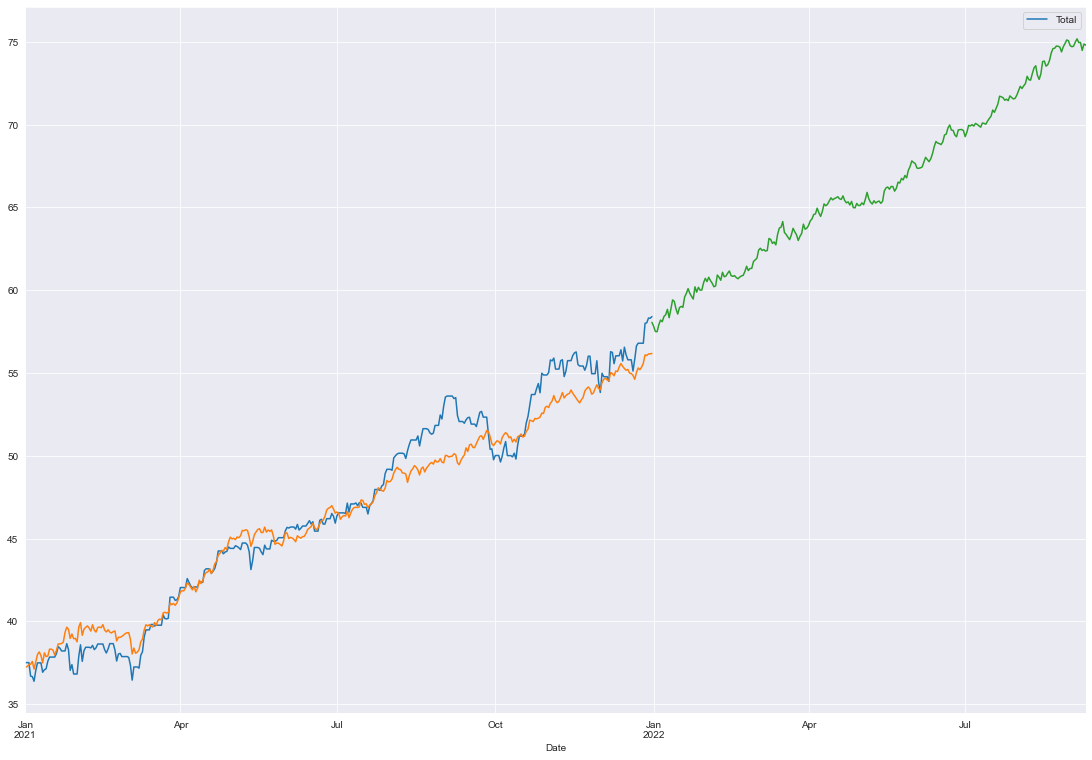

In [54]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [55]:
## Calculate annualized returns for forecasted

In [56]:
forecast

2021-12-31    58.060157
2022-01-01    57.822530
2022-01-02    57.510228
2022-01-03    57.496982
2022-01-04    57.914276
                ...    
2022-09-05    74.961018
2022-09-06    74.961961
2022-09-07    74.484132
2022-09-08    74.871134
2022-09-09    74.807017
Freq: D, Length: 253, dtype: float64

In [57]:
forecast_df = pd.DataFrame(forecast)

In [58]:
forecast_df

,0
2021-12-31,58.060157
2022-01-01,57.822530
2022-01-02,57.510228
2022-01-03,57.496982
2022-01-04,57.914276
...,...
2022-09-05,74.961018
2022-09-06,74.961961
2022-09-07,74.484132
2022-09-08,74.871134


In [59]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [60]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.004093
2022-01-02,-0.009472
2022-01-03,-0.009700
2022-01-04,-0.002513
...,...
2022-09-05,0.291092
2022-09-06,0.291108
2022-09-07,0.282879
2022-09-08,0.289544


In [61]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                   0
2022-09-09  28.84398
